In [3]:
from scipy.stats.mstats import ttest_ind
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker

In [4]:
f_sst=xr.open_dataset(r"D:\data\short_term_climate_class\sx06\HadISST_sst.nc", drop_variables=["time_bnds"])
f_sst

<xarray.Dataset>
Dimensions:    (time: 1827, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2022-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    5/5/2022 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

# 雨型年

In [5]:
type_1_year=np.array([1953,1958,1959,1960,1961,1964,1966,1967,1973,1976,
                      1977,1978,1981,1985,1988,1992,1994,1995,2001,2004])
type_2_year=np.array([1956,1957,1962,1963,1965,1971,1972,1975,1979,1982,
                      1984,1989,1990,1991,2000,2003,2005])
type_3_year=np.array([1951,1952,1954,1955,1968,1969,1970,1974,1980,1983,
                      1986,1987,1993,1996,1997,1998,1999,2002])

In [6]:
#提取海温
sst = f_sst.sst.loc[f_sst.time.dt.month.isin([12, 1,2])].loc['1950-12-16':'2005-02-15',60:-60, :]
sst

<xarray.DataArray 'sst' (time: 165, latitude: 120, longitude: 360)>
[7128000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1950-12-16T12:00:00 ... 2005-02-15
  * latitude   (latitude) float32 59.5 58.5 57.5 56.5 ... -57.5 -58.5 -59.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [203]:
#计算合成 并 T检验
def cal_data(type_year, data):
    ave_data = (np.array(data).reshape(-1, 3, data.shape[1], data.shape[2]).mean(1)).mean(0)
    chose_data = data.loc[((data.time.dt.month.isin([1, 2])) &
                 (data.time.dt.year.isin(type_year))) |
                ((data.time.dt.month.isin([12])) &
                 (data.time.dt.year.isin(type_year - 1)))]
    data_winter = (np.array(chose_data).reshape(-1, 3, data.shape[1], data.shape[2]).mean(1)).mean(0)
    data_jp = data_winter - ave_data
    #T检验
    _, p_data = ttest_ind(chose_data, data, equal_var=False)
    return data_jp, p_data


sst_1_winter, p_sst_1 = cal_data(type_1_year, sst)
sst_2_winter, p_sst_2 = cal_data(type_2_year, sst)
sst_3_winter, p_sst_3 = cal_data(type_3_year, sst)

In [79]:
sst.shape[1]

120

In [8]:
sst_1_winter[sst_1_winter>1.5]

array([ 6.1241727,  6.118939 ,  6.021119 ,  6.0230103, 30.235199 ,
       15.111435 ,  6.047531 , 19.652481 , 57.46138  , 52.930145 ,
       10.567902 , 27.210724 ,  9.049561 , 21.143295 , 18.127151 ,
       58.969997 , 21.11892  ,  7.6189785, 12.123207 ,  6.10746  ,
        6.1597133, 18.26657  ,  6.1961784,  6.2069025,  6.1589656,
        6.1277933,  6.0384216, 15.110764 , 15.101471 , 18.12732  ,
       12.079987 ,  4.5099335,  4.5299225, 42.359497 , 33.303467 ,
        9.069317 , 11.99105  , 28.728424 , 21.160034 , 52.919495 ,
       52.92096  , 10.580887 , 31.741974 ,  6.040451 , 22.693321 ,
       22.70642  , 43.90406  ,  5.953268 , 24.187958 , 24.198853 ,
       45.351364 ,  4.516926 ,  1.5260696, 63.543957 ,  3.08078  ,
       18.159973 , 30.244171 , 51.408234 ,  3.0525894,  3.0859451,
        9.06263  , 21.152473 ,  6.1057377,  6.163293 , 39.343742 ,
       34.796795 , 15.195572 , 15.218651 , 31.914528 , 21.31348  ,
       36.28238  , 13.570799 ,  6.0310674, 83.407486 , 28.9457

C:\Users\Serein\AppData\Local\Temp\ipykernel_4592\3808955265.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)


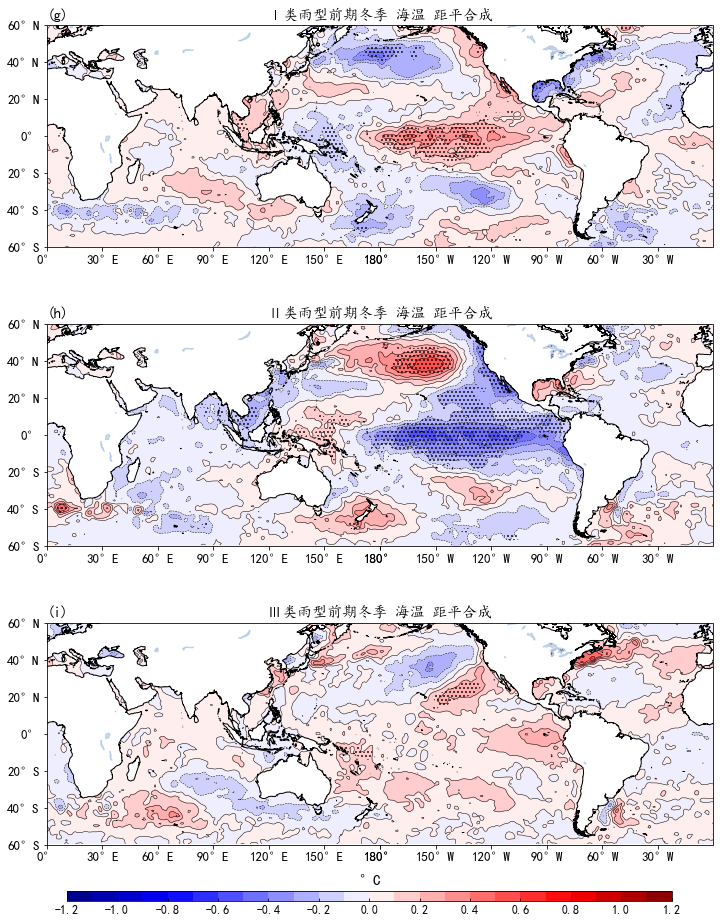

In [225]:
def contour_map(fig, img_extent, spec_x,spec_y,data_jp,data_lon,data_lat,lev,cmap,p_hgt,title,number):  # 画布，经纬度范围，步长
    c_data_jp, cycle_lon = add_cyclic_point(data_jp, coord=data_lon)
    c_data_lon, c_data_lat = np.meshgrid(cycle_lon,data_lat)
    fig.set_xlim((img_extent[0], img_extent[1]))
    fig.set_ylim((img_extent[2], img_extent[3]))
    fig.add_feature(cfeature.COASTLINE.with_scale('50m'),zorder=1)  # 添加海岸线
    fig.add_feature(cfeature.LAKES, alpha=0.5,zorder=1)  # 添加湖泊
    # 添加经纬度
    fig.set_xticks(np.arange(img_extent[0], img_extent[1] + spec_x, spec_x),
                   crs=ccrs.PlateCarree())
    fig.set_yticks(np.arange(img_extent[2], img_extent[3] + spec_y, spec_y),
                   crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    fig.xaxis.set_major_formatter(lon_formatter)
    fig.yaxis.set_major_formatter(lat_formatter)
    plt.xticks(fontsize=13)  # 设置标签大小
    plt.yticks(fontsize=13)
    c_cbar = fig.contourf(c_data_lon,
                    c_data_lat,
                    c_data_jp,
                    levels=lev,
                    cmap=cmap,
                    zorder=0,
                    transform=ccrs.PlateCarree())
    fig.contour(c_cbar, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    c1p = fig.contourf(data_lon,
                     data_lat,
                     p_hgt,
                     levels=[0, 0.05, 1],
                     hatches=['...', None],
                     colors="none",
                     transform=ccrs.PlateCarree())
    fig.set_title(title, fontsize=15)
    fig.set_title(number, loc='left', fontsize=15)
    return c_cbar


lev = np.arange(-1.2, 1.21,0.1)
cmap=cmaps.NCV_blue_red
fig_2 = plt.figure(figsize=(15, 12))
#海温
img_extent=[-180, 180, -60, 60]
proj=ccrs.PlateCarree(central_longitude=180)

f_ax1 = fig_2.add_subplot(3, 1, 1, projection=proj)
c3=contour_map(f_ax1, img_extent, 30,20,sst_1_winter,sst.longitude,sst.latitude,lev,cmap,p_sst_1,'Ⅰ类雨型前期冬季 海温 距平合成','(g)')

f_ax2 = fig_2.add_subplot(3, 1,2 , projection=proj)
contour_map(f_ax2, img_extent, 30,20,sst_2_winter,sst.longitude,sst.latitude,lev,cmap,p_sst_2,'Ⅱ类雨型前期冬季 海温 距平合成','(h)')

f_ax3 = fig_2.add_subplot(3, 1, 3, projection=proj)
contour_map(f_ax3, img_extent, 30,20,sst_3_winter,sst.longitude,sst.latitude,lev,cmap,p_sst_3,'Ⅲ类雨型前期冬季 海温 距平合成','(i)')

axc = fig_2.add_axes([0.21, -0.04, 0.56, 0.012])
cbar = plt.colorbar(c3, cax=axc, orientation='horizontal')
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-1.2, 1.21,0.2))
cbar.ax.set_title('°C', fontsize=15)

plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)
# plt.savefig(r'D:\data\short_term_climate_class\sx05\pre.jpg',
#             dpi=300,
#             bbox_inches='tight')
plt.show()

C:\Users\Serein\AppData\Local\Temp\ipykernel_4592\1509461971.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, w_pad=8, h_pad=2)


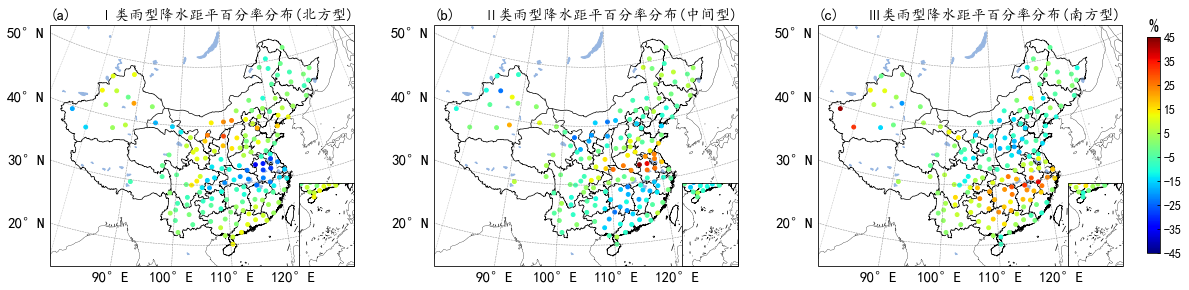

In [193]:
from scipy.stats.mstats import ttest_ind
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
#防止中文出错
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

#6月份降水
f_pre_6 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1606.txt",
                      sep="\s+",
                      header=None)
pre_6 = np.array(f_pre_6).reshape(71, 160)
#7月份降水
f_pre_7 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1607.txt",
                      sep="\s+",
                      header=None)
pre_7 = np.array(f_pre_7).reshape(71, 160)
#8月份降水
f_pre_8 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1608.txt",
                      sep="\s+",
                      header=None)
pre_8 = np.array(f_pre_8).reshape(71, 160)

pre = ((pre_6 + pre_7 + pre_8) / 3.)[0:55, :]
#高度
f_hgt = xr.open_dataset(
    r"D:\data\short_term_climate_class\sx05\hgt.mon.mean.nc")
#500hPa
z = f_hgt.hgt.loc[f_hgt.time.dt.month.isin(
    [12, 1,2])].loc['1950-12-01':'2005-02-01',500, 90:0, :]
#站点
sta = pd.read_csv(r"D:\data\short_term_climate_class\sx05\zd.txt",
                  sep="\s+",
                  header=None,
                  names=['station', 'lat', 'lon'])
#海温
f_sst=xr.open_dataset(r"D:\data\short_term_climate_class\sx06\HadISST_sst.nc", drop_variables=["time_bnds"])
#提取海温
sst = f_sst.sst.loc[f_sst.time.dt.month.isin([12, 1,2])].loc['1950-12-16':'2005-02-15',60:-60, :]

type_1_year=np.array([1953,1958,1959,1960,1961,1964,1966,1967,1973,1976,
                      1977,1978,1981,1985,1988,1992,1994,1995,2001,2004])
type_2_year=np.array([1956,1957,1962,1963,1965,1971,1972,1975,1979,1982,
                      1984,1989,1990,1991,2000,2003,2005])
type_3_year=np.array([1951,1952,1954,1955,1968,1969,1970,1974,1980,1983,
                      1986,1987,1993,1996,1997,1998,1999,2002])

#计算雨型
def cal_pre(type_year, pre):
    type_year_pre = pre[type_year - 1951]
    ave_pre = np.tile((pre[0:50, :]).mean(0), (type_year_pre.shape[0], 1))
    pre_per = ((type_year_pre - ave_pre) / ave_pre).mean(0)
    return pre_per


pre_per_1 = cal_pre(type_1_year, pre)
pre_per_2 = cal_pre(type_2_year, pre)
pre_per_3 = cal_pre(type_3_year, pre)


#计算合成 并 T检验
def cal_data(type_year, data):
    ave_data = (np.array(data).reshape(-1, 3, data.shape[1], data.shape[2]).mean(1)).mean(0)
    chose_data = data.loc[((data.time.dt.month.isin([1, 2])) &
                 (data.time.dt.year.isin(type_year))) |
                ((data.time.dt.month.isin([12])) &
                 (data.time.dt.year.isin(type_year - 1)))]
    data_winter = (np.array(chose_data).reshape(-1, 3, data.shape[1], data.shape[2]).mean(1)).mean(0)
    data_jp = data_winter - ave_data
    #T检验
    _, p_data = ttest_ind(chose_data, data, equal_var=False)
    return data_jp, p_data

hgt_1_winter, p_hgt_1 = cal_data(type_1_year, z)
hgt_2_winter, p_hgt_2 = cal_data(type_2_year, z)
hgt_3_winter, p_hgt_3 = cal_data(type_3_year, z)

#散点底图
def Lbt_map(ax, extent,sta,pre_per,title=None,number=None,mark=None):
    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE, lw=0.3)
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
#     ax.add_geometries(Reader(r"D:\data\china_map\river1.shp").geometries(),
#                       ccrs.PlateCarree(),
#                       facecolor='none',
#                       edgecolor='b',
#                       linewidth=0.6)
#     ax.add_geometries(Reader(r'D:\data\china_map\china1.shp').geometries(),
#                       ccrs.PlateCarree(),
#                       facecolor='none',
#                       edgecolor='k',
#                       linewidth=0.5)
    ax.add_geometries(Reader(r"D:\data\map\bou2_4l.shp").geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='k',
                      linewidth=0.7)
#     ax.add_geometries(
#         Reader(r'D:\data\china_map\ne_10m_land.shp').geometries(),
#         ccrs.PlateCarree(),
#         facecolor='none',
#         edgecolor='k',
#         linewidth=0.5)
#     ax.add_geometries(
#         Reader(r'D:\data\china_map\ne_50m_lakes.shp').geometries(),
#         ccrs.PlateCarree(),
#         facecolor='none',
#         edgecolor='k',
#         linewidth=0.5)
    if mark == 1:
        lb = ax.gridlines(draw_labels=None,
                          x_inline=False,
                          y_inline=False,
                          linewidth=0.5,
                          color='gray',
                          alpha=0.5,
                          linestyle='--')
        lb.xlocator = mticker.FixedLocator(range(0, 180, 10))
        lb.ylocator = mticker.FixedLocator(range(0, 90, 10))
        lb = ax.gridlines(draw_labels=True,
                          x_inline=False,
                          y_inline=False,
                          linewidth=0.5,
                          color='gray',
                          alpha=0.5,
                          linestyle='--')
        lb.top_labels = False
        lb.right_labels = None
        lb.xlocator = mticker.FixedLocator(range(90, 130, 10))
        lb.ylocator = mticker.FixedLocator(range(10, 60, 10))
        lb.ylabel_style = {'size': 15, 'color': 'k'}
        lb.xlabel_style = {'size': 15, 'color': 'k'}
        lb.rotate_labels = False
    else:
        pass
    
    cb=ax.scatter(sta["lon"],
            sta["lat"],
            vmin=-45,
            vmax=45,
            s=15,
            c=pre_per * 100,
            cmap='jet',
            transform=ccrs.PlateCarree())
    ax.set_title(title, loc='right', fontsize=15)
    ax.set_title(number, loc='left', fontsize=15)
    return cb

#画布
fig_1 = plt.figure(figsize=(15, 5))
#降水
map = ccrs.LambertConformal(central_longitude=105)

ax1 = fig_1.add_subplot(1, 3, 1, projection=map)
c11 =Lbt_map(ax1, [80, 130, 15, 55],sta,pre_per_1,'Ⅰ类雨型降水距平百分率分布(北方型)','(a)',1)


ax2 = fig_1.add_subplot(1, 3, 2, projection=map)
c12 =Lbt_map(ax2, [80, 130, 15, 55], sta,pre_per_2,'Ⅱ类雨型降水距平百分率分布(中间型)','(b)',1)


ax3 = fig_1.add_subplot(1, 3, 3, projection=map)
c13 =Lbt_map(ax3, [80, 130, 15, 55],sta,pre_per_3,'Ⅲ类雨型降水距平百分率分布(南方型)','(c)',1)

#色标
ax = fig_1.add_axes([1.02, 0.2, 0.012, 0.6])
cbar = plt.colorbar(c11, cax=ax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-45, 45.1, 10))
cbar.ax.set_title('%', fontsize=20)

#南海
ax_nh1 = fig_1.add_axes([0.105, 0.165, 0.31, 0.23],
                      projection=ccrs.PlateCarree())
Lbt_map(ax_nh1, [106, 122, 0, 24], sta,pre_per_1)

ax_nh2 = fig_1.add_axes([0.46, 0.165, 0.31, 0.23],
                      projection=ccrs.PlateCarree())
Lbt_map(ax_nh2, [106, 122, 0, 24], sta,pre_per_2)

ax_nh3 = fig_1.add_axes([0.817, 0.165, 0.31, 0.23],
                      projection=ccrs.PlateCarree())
Lbt_map(ax_nh3, [106, 122, 0, 24], sta,pre_per_3)


plt.tight_layout(pad=0.4, w_pad=8, h_pad=2)

plt.show()


C:\Users\Serein\AppData\Local\Temp\ipykernel_4592\3096353566.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)


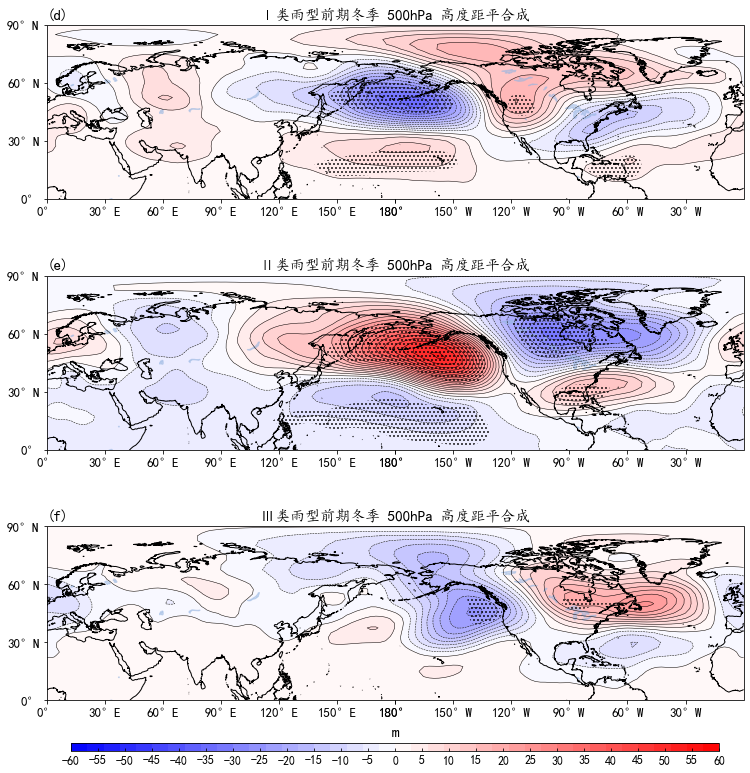

In [226]:
def contour_map(fig, img_extent, spec_x,spec_y,data_jp,data_lon,data_lat,lev,cmap,p_hgt,title,number):  # 画布，经纬度范围，步长
    c_data_jp, cycle_lon = add_cyclic_point(data_jp, coord=data_lon)
    c_data_lon, c_data_lat = np.meshgrid(cycle_lon,data_lat)
    fig.set_xlim((img_extent[0], img_extent[1]))
    fig.set_ylim((img_extent[2], img_extent[3]))
    fig.add_feature(cfeature.COASTLINE.with_scale('50m'),zorder=1)  # 添加海岸线
    fig.add_feature(cfeature.LAKES, alpha=0.5,zorder=1)  # 添加湖泊
    # 添加经纬度
    fig.set_xticks(np.arange(img_extent[0], img_extent[1] + spec_x, spec_x),
                   crs=ccrs.PlateCarree())
    fig.set_yticks(np.arange(img_extent[2], img_extent[3] + spec_y, spec_y),
                   crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    fig.xaxis.set_major_formatter(lon_formatter)
    fig.yaxis.set_major_formatter(lat_formatter)
    plt.xticks(fontsize=13)  # 设置标签大小
    plt.yticks(fontsize=13)
    c_cbar = fig.contourf(c_data_lon,
                    c_data_lat,
                    c_data_jp,
                    levels=lev,
                    cmap=cmap,
                    zorder=0,
                    transform=ccrs.PlateCarree())
    fig.contour(c_cbar, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    c1p = fig.contourf(data_lon,
                     data_lat,
                     p_hgt,
                     levels=[0, 0.05, 1],
                     hatches=['...', None],
                     colors="none",
                     transform=ccrs.PlateCarree())
    fig.set_title(title, fontsize=15)
    fig.set_title(number, loc='left', fontsize=15)
    return c_cbar


def cycle_data(hgt_jp, z):
    chgt, cycle_lon = add_cyclic_point(hgt_jp, coord=z.lon)
    LON, LAT = np.meshgrid(cycle_lon, z.lat)
    return LON, LAT, chgt

lev = np.arange(-60, 60.1, 3)
cmap='bwr'
fig_2 = plt.figure(figsize=(15, 10))
#500hPa
img_extent=[-180, 180, 0, 90]
proj=ccrs.PlateCarree(central_longitude=180)

f_ax1 = fig_2.add_subplot(3, 1, 1, projection=proj)
c3=contour_map(f_ax1, img_extent, 30,30,hgt_1_winter,z.lon,z.lat,lev,cmap,p_hgt_1,'Ⅰ类雨型前期冬季 500hPa 高度距平合成','(d)')

f_ax2 = fig_2.add_subplot(3, 1,2 , projection=proj)
contour_map(f_ax2, img_extent, 30,30,hgt_2_winter,z.lon,z.lat,lev,cmap,p_hgt_2,'Ⅱ类雨型前期冬季 500hPa 高度距平合成','(e)')

f_ax3 = fig_2.add_subplot(3, 1, 3, projection=proj)
contour_map(f_ax3, img_extent, 30,30,hgt_3_winter,z.lon,z.lat,lev,cmap,p_hgt_3,'Ⅲ类雨型前期冬季 500hPa 高度距平合成','(f)')

axc = fig_2.add_axes([0.2, -0.04, 0.60, 0.012])
cbar = plt.colorbar(c3, cax=axc, orientation='horizontal')
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-60, 60.1, 5))
cbar.ax.set_title('m', fontsize=15)

plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)
# plt.savefig(r'D:\data\short_term_climate_class\sx05\pre.jpg',
#             dpi=300,
#             bbox_inches='tight')
plt.show()

# 完整代码

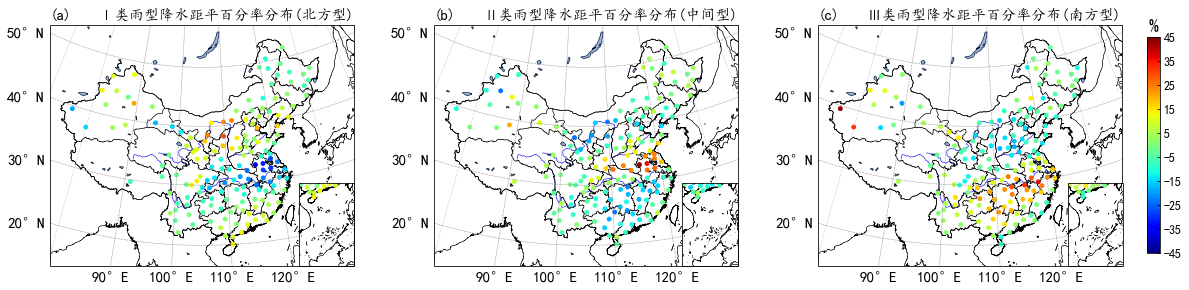

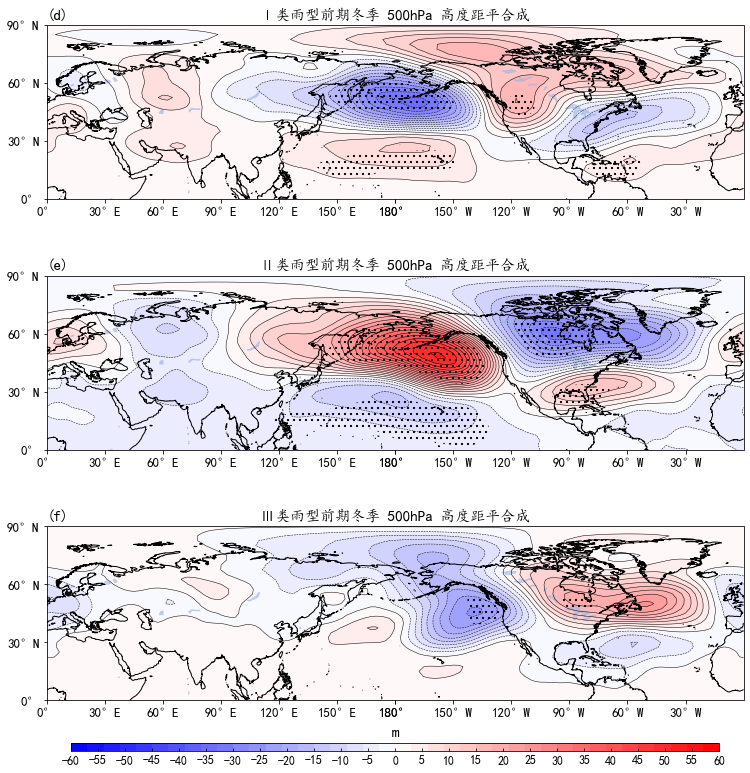

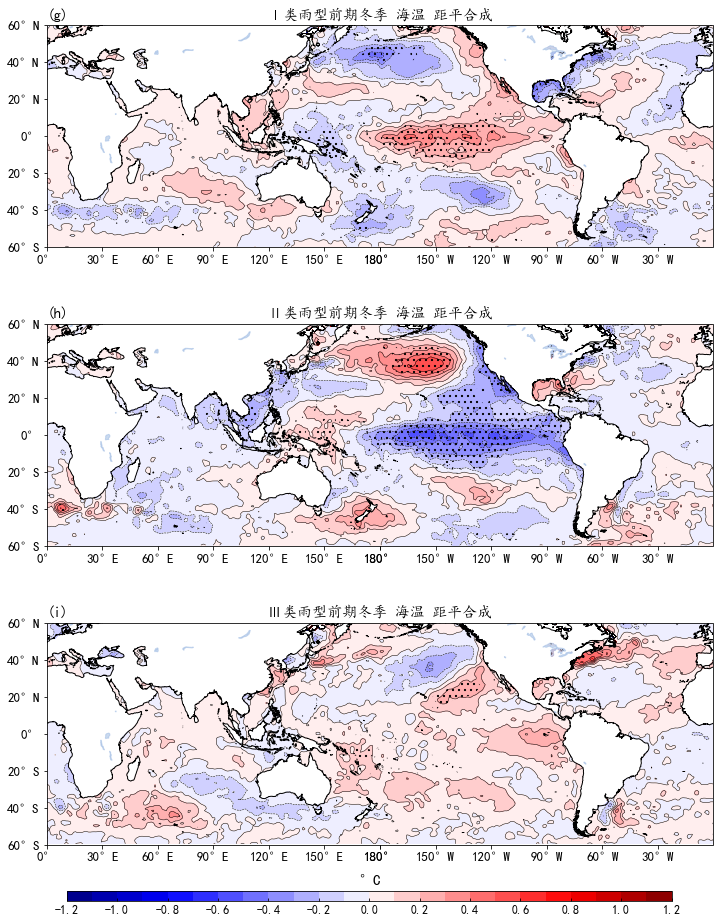

In [4]:
from scipy.stats.mstats import ttest_ind
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import numpy as np
import cmaps
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import warnings
#忽略警告
warnings.filterwarnings("ignore")
#防止中文出错
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

#6月份降水
f_pre_6 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1606.txt",
                      sep="\s+",
                      header=None)
pre_6 = np.array(f_pre_6).reshape(71, 160)

#7月份降水
f_pre_7 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1607.txt",
                      sep="\s+",
                      header=None)
pre_7 = np.array(f_pre_7).reshape(71, 160)

#8月份降水
f_pre_8 = pd.read_csv(r"D:\data\short_term_climate_class\sx05\r1608.txt",
                      sep="\s+",
                      header=None)
pre_8 = np.array(f_pre_8).reshape(71, 160)

pre = ((pre_6 + pre_7 + pre_8) / 3.)[0:55, :]

#高度
f_hgt = xr.open_dataset(
    r"D:\data\short_term_climate_class\sx05\hgt.mon.mean.nc")
#500hPa
z = f_hgt.hgt.loc[f_hgt.time.dt.month.isin(
    [12, 1,2])].loc['1950-12-01':'2005-02-01',500, 90:0, :]

#站点
sta = pd.read_csv(r"D:\data\short_term_climate_class\sx05\zd.txt",
                  sep="\s+",
                  header=None,
                  names=['station', 'lat', 'lon'])

#海温
f_sst = xr.open_dataset(
    r"D:\data\short_term_climate_class\sx06\HadISST_sst.nc",
    drop_variables=["time_bnds"])
#提取海温
sst = f_sst.sst.loc[f_sst.time.dt.month.isin(
    [12, 1, 2])].loc['1950-12-16':'2005-02-15', 60:-60, :]

type_1_year = np.array([
    1953, 1958, 1959, 1960, 1961, 1964, 1966, 1967, 1973, 1976, 1977, 1978,
    1981, 1985, 1988, 1992, 1994, 1995, 2001, 2004])
type_2_year = np.array([
    1956, 1957, 1962, 1963, 1965, 1971, 1972, 1975, 1979, 1982, 1984, 1989,
    1990, 1991, 2000, 2003, 2005])
type_3_year = np.array([
    1951, 1952, 1954, 1955, 1968, 1969, 1970, 1974, 1980, 1983, 1986, 1987,
    1993, 1996, 1997, 1998, 1999, 2002])


#计算雨型
def cal_pre(type_year, pre):
    type_year_pre = pre[type_year - 1951]
    ave_pre = np.tile((pre[0:50, :]).mean(0), (type_year_pre.shape[0], 1))
    pre_per = ((type_year_pre - ave_pre) / ave_pre).mean(0)
    return pre_per

pre_per_1 = cal_pre(type_1_year, pre)
pre_per_2 = cal_pre(type_2_year, pre)
pre_per_3 = cal_pre(type_3_year, pre)


#计算合成 并 T检验
def cal_data(type_year, data):
    ave_data = (np.array(data).reshape(-1, 3, data.shape[1],
                                       data.shape[2]).mean(1)).mean(0)
    chose_data = data.loc[((data.time.dt.month.isin([1, 2])) &
                           (data.time.dt.year.isin(type_year))) |
                          ((data.time.dt.month.isin([12])) &
                           (data.time.dt.year.isin(type_year - 1)))]
    data_winter = (np.array(chose_data).reshape(-1, 3, 
                   data.shape[1],data.shape[2]).mean(1)).mean(0)
    data_jp = data_winter - ave_data
    #T检验
    _, p_data = ttest_ind(chose_data, data, equal_var=False)
    return data_jp, p_data

#500hPa
hgt_1_winter, p_hgt_1 = cal_data(type_1_year, z)
hgt_2_winter, p_hgt_2 = cal_data(type_2_year, z)
hgt_3_winter, p_hgt_3 = cal_data(type_3_year, z)
#海温
sst_1_winter, p_sst_1 = cal_data(type_1_year, sst)
sst_2_winter, p_sst_2 = cal_data(type_2_year, sst)
sst_3_winter, p_sst_3 = cal_data(type_3_year, sst)


#散点底图
def Lbt_map(ax, extent, sta, pre_per, title=None, number=None, mark=None):
    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE, lw=0.3)
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
    ax.add_geometries(Reader(r"D:\data\china_map\river1.shp").geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='b',
                      linewidth=0.6)
    ax.add_geometries(Reader(r'D:\data\china_map\china1.shp').geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='k',
                      linewidth=0.5)
    ax.add_geometries(Reader(r"D:\data\map\bou2_4l.shp").geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='k',
                      linewidth=0.7)
    ax.add_geometries(
            Reader(r'D:\data\china_map\ne_10m_land.shp').geometries(),
            ccrs.PlateCarree(),
            facecolor='none',
            edgecolor='k',
            linewidth=0.5)
    ax.add_geometries(
            Reader(r'D:\data\china_map\ne_50m_lakes.shp').geometries(),
            ccrs.PlateCarree(),
            facecolor='none',
            edgecolor='k',
            linewidth=0.5)
    if mark == 1:
        lb = ax.gridlines(draw_labels=None,
                          x_inline=False,
                          y_inline=False,
                          linewidth=0.5,
                          color='gray',
                          alpha=0.5,
                          linestyle='--')
        lb.xlocator = mticker.FixedLocator(range(0, 180, 10))
        lb.ylocator = mticker.FixedLocator(range(0, 90, 10))
        lb = ax.gridlines(draw_labels=True,
                          x_inline=False,
                          y_inline=False,
                          linewidth=0.5,
                          color='gray',
                          alpha=0.5,
                          linestyle='--')
        lb.top_labels = False
        lb.right_labels = None
        lb.xlocator = mticker.FixedLocator(range(90, 130, 10))
        lb.ylocator = mticker.FixedLocator(range(10, 60, 10))
        lb.ylabel_style = {'size': 15, 'color': 'k'}
        lb.xlabel_style = {'size': 15, 'color': 'k'}
        lb.rotate_labels = False
    else:
        pass

    cb = ax.scatter(sta["lon"],
                    sta["lat"],
                    vmin=-45,
                    vmax=45,
                    s=15,
                    c=pre_per * 100,
                    cmap='jet',
                    transform=ccrs.PlateCarree())
    ax.set_title(title, loc='right', fontsize=15)
    ax.set_title(number, loc='left', fontsize=15)
    return cb


def contour_map(fig, img_extent, spec_x, spec_y, data_jp, data_lon, data_lat,
                lev, cmap, p_hgt, title, number):  # 画布，经纬度范围，步长
    c_data_jp, cycle_lon = add_cyclic_point(data_jp, coord=data_lon)
    c_data_lon, c_data_lat = np.meshgrid(cycle_lon, data_lat)
    fig.set_xlim((img_extent[0], img_extent[1]))
    fig.set_ylim((img_extent[2], img_extent[3]))
    fig.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=1)  # 添加海岸线
    fig.add_feature(cfeature.LAKES, alpha=0.5, zorder=1)  # 添加湖泊
    # 添加经纬度
    fig.set_xticks(np.arange(img_extent[0], img_extent[1] + spec_x, spec_x),
                   crs=ccrs.PlateCarree())
    fig.set_yticks(np.arange(img_extent[2], img_extent[3] + spec_y, spec_y),
                   crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    fig.xaxis.set_major_formatter(lon_formatter)
    fig.yaxis.set_major_formatter(lat_formatter)
    plt.xticks(fontsize=13)  # 设置标签大小
    plt.yticks(fontsize=13)
    c_cbar = fig.contourf(c_data_lon,
                          c_data_lat,
                          c_data_jp,
                          levels=lev,
                          cmap=cmap,
                          zorder=0,
                          transform=ccrs.PlateCarree())
    fig.contour(c_cbar,
                colors='black',
                linewidths=0.5,
                transform=ccrs.PlateCarree())
    c1p = fig.contourf(data_lon,
                       data_lat,
                       p_hgt,
                       levels=[0, 0.05, 1],
                       hatches=['..', None],
                       colors="none",
                       transform=ccrs.PlateCarree())
    fig.set_title(title, fontsize=15)
    fig.set_title(number, loc='left', fontsize=15)
    return c_cbar


#画布1
fig_1 = plt.figure(figsize=(15, 5))
#降水
map = ccrs.LambertConformal(central_longitude=105)

ax1 = fig_1.add_subplot(1, 3, 1, projection=map)
c11 = Lbt_map(ax1, [80, 130, 15, 55], sta, pre_per_1, 
            'Ⅰ类雨型降水距平百分率分布(北方型)','(a)', 1)

ax2 = fig_1.add_subplot(1, 3, 2, projection=map)
c12 = Lbt_map(ax2, [80, 130, 15, 55], sta, pre_per_2, 
            'Ⅱ类雨型降水距平百分率分布(中间型)','(b)', 1)

ax3 = fig_1.add_subplot(1, 3, 3, projection=map)
c13 = Lbt_map(ax3, [80, 130, 15, 55], sta, pre_per_3, 
            'Ⅲ类雨型降水距平百分率分布(南方型)','(c)', 1)

#色标
ax = fig_1.add_axes([1.02, 0.2, 0.012, 0.6])
cbar = plt.colorbar(c11, cax=ax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-45, 45.1, 10))
cbar.ax.set_title('%', fontsize=20)

#南海
ax_nh1 = fig_1.add_axes([0.105, 0.165, 0.31, 0.23],
                        projection=ccrs.PlateCarree())
Lbt_map(ax_nh1, [106, 122, 0, 24], sta, pre_per_1)

ax_nh2 = fig_1.add_axes([0.46, 0.165, 0.31, 0.23],
                        projection=ccrs.PlateCarree())
Lbt_map(ax_nh2, [106, 122, 0, 24], sta, pre_per_2)

ax_nh3 = fig_1.add_axes([0.817, 0.165, 0.31, 0.23],
                        projection=ccrs.PlateCarree())
Lbt_map(ax_nh3, [106, 122, 0, 24], sta, pre_per_3)

plt.tight_layout(pad=0.4, w_pad=8, h_pad=2)
plt.savefig(r'D:\data\short_term_climate_class\sx06\pre.jpg',
            dpi=300,
            bbox_inches='tight')

#画布2
fig_2 = plt.figure(figsize=(15, 10))
#500hPa
lev_hgt = np.arange(-60, 60.1, 3)
cmap = 'bwr'
img_extent = [-180, 180, 0, 90]
proj_hgt = ccrs.PlateCarree(central_longitude=180)

f_ax1 = fig_2.add_subplot(3, 1, 1, projection=proj_hgt)
c3 = contour_map(f_ax1, img_extent, 30, 30, hgt_1_winter, z.lon, z.lat,
       lev_hgt, cmap, p_hgt_1, 'Ⅰ类雨型前期冬季 500hPa 高度距平合成', '(d)')

f_ax2 = fig_2.add_subplot(3, 1, 2, projection=proj_hgt)
contour_map(f_ax2, img_extent, 30, 30, hgt_2_winter, z.lon, z.lat, lev_hgt,
            cmap, p_hgt_2, 'Ⅱ类雨型前期冬季 500hPa 高度距平合成', '(e)')

f_ax3 = fig_2.add_subplot(3, 1, 3, projection=proj_hgt)
contour_map(f_ax3, img_extent, 30, 30, hgt_3_winter, z.lon, z.lat, lev_hgt,
            cmap, p_hgt_3, 'Ⅲ类雨型前期冬季 500hPa 高度距平合成', '(f)')

#色标
axc = fig_2.add_axes([0.2, -0.04, 0.60, 0.012])
cbar = plt.colorbar(c3, cax=axc, orientation='horizontal')
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-60, 60.1, 5))
cbar.ax.set_title('m', fontsize=15)

plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)
plt.savefig(r'D:\data\short_term_climate_class\sx06\hgt.jpg',
            dpi=300,
            bbox_inches='tight')

#画布3
fig_3 = plt.figure(figsize=(15, 12))
#海温
lev_sst = np.arange(-1.2, 1.21, 0.1)
cmap = cmaps.NCV_blue_red
img_extent = [-180, 180, -60, 60]
proj_sst = ccrs.PlateCarree(central_longitude=180)

f_ax1 = fig_3.add_subplot(3, 1, 1, projection=proj_sst)
c3 = contour_map(f_ax1, img_extent, 30, 20, sst_1_winter, sst.longitude,
            sst.latitude, lev_sst, cmap, p_sst_1, 'Ⅰ类雨型前期冬季 海温 距平合成','(g)')

f_ax2 = fig_3.add_subplot(3, 1, 2, projection=proj_sst)
contour_map(f_ax2, img_extent, 30, 20, sst_2_winter, sst.longitude,
        sst.latitude, lev_sst, cmap, p_sst_2, 'Ⅱ类雨型前期冬季 海温 距平合成', '(h)')

f_ax3 = fig_3.add_subplot(3, 1, 3, projection=proj_sst)
contour_map(f_ax3, img_extent, 30, 20, sst_3_winter, sst.longitude,
        sst.latitude, lev_sst, cmap, p_sst_3, 'Ⅲ类雨型前期冬季 海温 距平合成', '(i)')

#色标
axc = fig_3.add_axes([0.21, -0.04, 0.56, 0.012])
cbar = plt.colorbar(c3, cax=axc, orientation='horizontal')
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.set_ticks(np.arange(-1.2, 1.21, 0.2))
cbar.ax.set_title('°C', fontsize=15)

plt.tight_layout(pad=0.4, w_pad=4, h_pad=4)
plt.savefig(r'D:\data\short_term_climate_class\sx06\sst.jpg',
            dpi=300,
            bbox_inches='tight')

plt.show()

## 最后修改为 2022-05-20-22:23
## 若有错误请联系 845728580@qq.com 订正